In [2]:
import pandas as pd
import numpy as np

np.random.seed(42)

# ----- 1. Suppliers -----
suppliers = pd.DataFrame({
    'supplier_id': range(1, 11),
    'supplier_name': [f'Supplier_{i}' for i in range(1, 11)],
    'avg_lead_time': np.random.randint(3, 15, size=10),
    'reliability_score': np.random.uniform(0.8, 1.0, size=10)
})

# ----- 2. Products -----
products = pd.DataFrame({
    'product_id': range(1, 101),
    'product_name': [f'Product_{i}' for i in range(1, 101)],
    'category': np.random.choice(['Electronics','Clothing','Home','Food'], 100),
    'supplier_id': np.random.choice(suppliers['supplier_id'], 100),
    'unit_cost': np.random.randint(5, 200, size=100),
    'lead_time_days': np.random.randint(3, 15, size=100)
})

# ----- 3. Inventory -----
inventory = pd.DataFrame({
    'product_id': products['product_id'],
    'current_stock': np.random.randint(20, 500, size=100),
    'reorder_point': np.random.randint(10, 50, size=100),
    'last_update': pd.to_datetime('2025-01-01')
})

# ----- 4. Sales -----
dates = pd.date_range(start='2025-01-01', end='2025-12-31')
sales_data = []

for product in products['product_id']:
    for date in dates:
        # Quantité vendue aléatoire, avec zéro certains jours
        qty = np.random.poisson(lam=np.random.randint(1, 10))
        if np.random.rand() < 0.1:  # 10% jours sans vente
            qty = 0
        sales_data.append([product, date, qty])

sales = pd.DataFrame(sales_data, columns=['product_id','sale_date','quantity_sold'])
sales['sale_id'] = range(1, len(sales)+1)

# Vérification
print(products.head())
print(suppliers.head())
print(inventory.head())
print(sales.head())


   product_id product_name     category  supplier_id  unit_cost  \
0           1    Product_1     Clothing            1        134   
1           2    Product_2     Clothing            9         58   
2           3    Product_3  Electronics            7         91   
3           4    Product_4         Food            9        133   
4           5    Product_5  Electronics            8        151   

   lead_time_days  
0               7  
1               6  
2              10  
3              10  
4               9  
   supplier_id supplier_name  avg_lead_time  reliability_score
0            1    Supplier_1              9           0.891850
1            2    Supplier_2              6           0.866742
2            3    Supplier_3             13           0.828573
3            4    Supplier_4             10           0.930178
4            5    Supplier_5              7           0.811282
   product_id  current_stock  reorder_point last_update
0           1            205             48

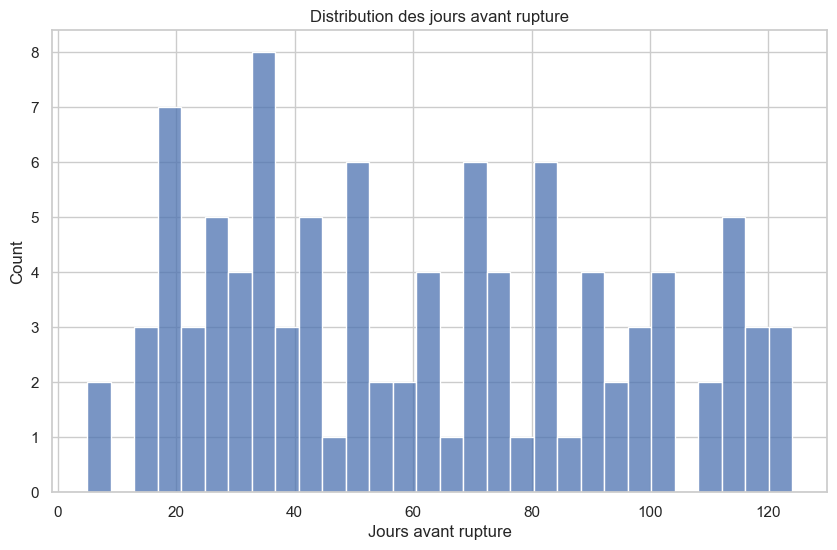

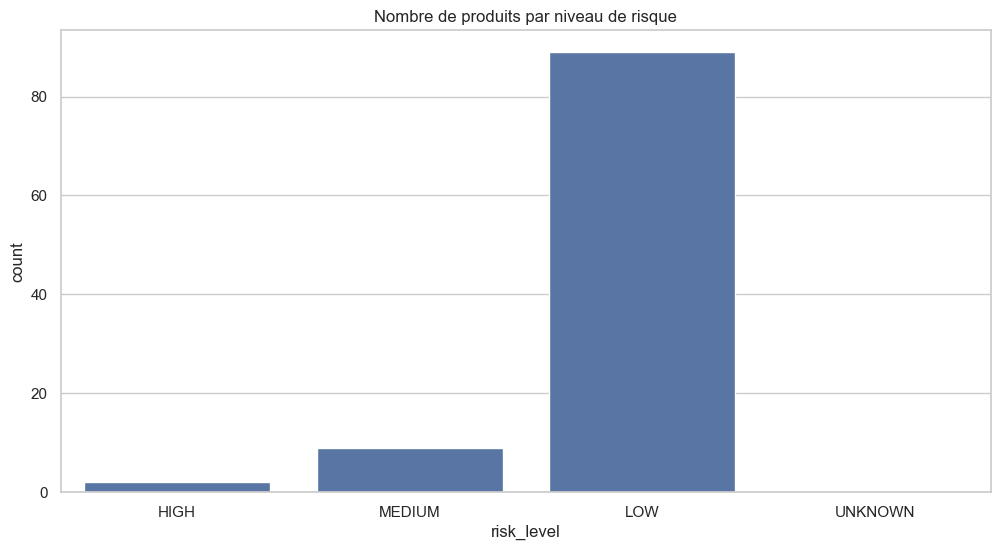

CSV exporté avec succès dans le dossier 'output'


In [3]:
# -----------------------------
# 1. Imports
# -----------------------------
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import os

sns.set(style="whitegrid")

# -----------------------------
# 2. Connexion à SQLite
# -----------------------------
conn = sqlite3.connect('../database/tables.db')

# -----------------------------
# 3. Charger les tables clés
# -----------------------------
products = pd.read_sql("SELECT * FROM products", conn)
inventory = pd.read_sql("SELECT * FROM inventory", conn)
sales = pd.read_sql("SELECT * FROM sales", conn)

# -----------------------------
# 4. Calcul des ventes moyennes journalières par produit (entier)
# -----------------------------
daily_sales = sales.groupby('product_id')['quantity_sold'].mean().reset_index()
daily_sales['avg_daily_sales'] = daily_sales['quantity_sold'].astype(int)
daily_sales = daily_sales[['product_id', 'avg_daily_sales']]

# Merge avec inventory et products
df = inventory.merge(products, on='product_id').merge(daily_sales, on='product_id')

# -----------------------------
# 5. Calcul des jours avant rupture (entier) et risque
# -----------------------------
df['days_until_stockout'] = np.floor(df['current_stock'] / df['avg_daily_sales']).replace([np.inf, -np.inf], np.nan).astype('Int64')

# Définir le risque
def risk_level(days):
    if pd.isna(days):
        return 'UNKNOWN'
    elif days < 10:
        return 'HIGH'
    elif days < 20:
        return 'MEDIUM'
    else:
        return 'LOW'

df['risk_level'] = df['days_until_stockout'].apply(risk_level)

# -----------------------------
# 6. Prévision simple 7 jours (moyenne mobile) par produit
# -----------------------------
sales['sale_date'] = pd.to_datetime(sales['sale_date'])
forecast = (
    sales.sort_values(['product_id', 'sale_date'])
    .groupby('product_id')['quantity_sold']
    .rolling(7, min_periods=1)
    .mean()
    .reset_index()
)
forecast.rename(columns={'quantity_sold':'forecast_7days'}, inplace=True)

# Récupérer le dernier forecast pour chaque produit
last_forecast = forecast.groupby('product_id').last().reset_index()[['product_id','forecast_7days']]
df = df.merge(last_forecast, on='product_id')

# -----------------------------
# 7. Visualisation
# -----------------------------
plt.figure(figsize=(10,6))
sns.histplot(df['days_until_stockout'].dropna(), bins=30, kde=False)
plt.title("Distribution des jours avant rupture")
plt.xlabel("Jours avant rupture")
plt.show()

plt.figure(figsize=(12,6))
sns.countplot(x='risk_level', data=df, order=['HIGH','MEDIUM','LOW','UNKNOWN'])
plt.title("Nombre de produits par niveau de risque")
plt.show()

# -----------------------------
# 8. Table finale pour business
# -----------------------------
final_table = df[['product_id','product_name','current_stock','reorder_point',
                  'avg_daily_sales','days_until_stockout','forecast_7days','risk_level']]

# Créer le dossier 'output' s'il n'existe pas
os.makedirs('output', exist_ok=True)

# Export CSV
final_table.to_csv('output/stock_alerts.csv', index=False)
print("CSV exporté avec succès dans le dossier 'output'")

# -----------------------------
# 9. Fermeture connexion SQLite
# -----------------------------
conn.close()
